<a href="https://colab.research.google.com/github/veydantkatyal/fraud-snap/blob/main/fraud_snappy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJECT SETUP**

In [5]:
# Install dependencies
!pip install torch torchvision pandas


In [6]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from PIL import Image
import cv2
import numpy as np


# **LOADING THE LABELLED DATASET**

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
# Define the path to your dataset in Google Drive
train_dir = '/content/drive/My Drive/doctor_bills_dataset/train'
val_dir = '/content/drive/My Drive/doctor_bills_dataset/val'


# **DATA TRANSFORMERS**

In [9]:
# Import necessary modules from PyTorch
import torch
from torch.utils.data import DataLoader  # Import DataLoader

from torchvision import datasets, transforms

# Define transformations for train and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets from the specified directories
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

# Define DataLoader for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # DataLoader defined correctly now
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# **MODEL DEFINITION(RESNET50)**

In [10]:
from torchvision import models
import torch.nn as nn

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 output classes: genuine and forged

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


# **HANDLING CLASS IMBALANCES**

In [11]:
# 2. Now handle class imbalance by calculating class weights
import os

# Check the number of images in each class for the training set
genuine_count = len(os.listdir(os.path.join(train_dir, 'genuine')))
forged_count = len(os.listdir(os.path.join(train_dir, 'forged')))
total_count = genuine_count + forged_count

# Print the number of genuine and forged images
print(f"Number of genuine documents in training set: {genuine_count}")
print(f"Number of forged documents in training set: {forged_count}")

# Inverse frequency of each class to calculate weights
genuine_weight = total_count / genuine_count
forged_weight = total_count / forged_count

# Create a tensor of weights (this will be passed to the loss function)
class_weights = torch.tensor([genuine_weight, forged_weight], dtype=torch.float).to(device)

# Use the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

Number of genuine documents in training set: 72
Number of forged documents in training set: 17


# **LOSS FUNCTION AND OPTIMIZER**

In [12]:
import torch.optim as optim

# Define the optimizer (SGD)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# **MODEL TRAINING**

In [13]:
# Define the training function
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization in the training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# Train the model for 10 epochs
trained_model = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------
train Loss: 0.3704 Acc: 0.7640
val Loss: 0.2256 Acc: 0.8182
Epoch 2/10
----------
train Loss: 0.2456 Acc: 0.8090
val Loss: 0.2474 Acc: 0.8182
Epoch 3/10
----------
train Loss: 0.2575 Acc: 0.8090
val Loss: 0.3054 Acc: 0.8182
Epoch 4/10
----------
train Loss: 0.2116 Acc: 0.8090
val Loss: 0.2473 Acc: 0.8182
Epoch 5/10
----------
train Loss: 0.1327 Acc: 0.8090
val Loss: 0.1861 Acc: 0.8182
Epoch 6/10
----------
train Loss: 0.1168 Acc: 0.8090
val Loss: 0.1691 Acc: 0.8182
Epoch 7/10
----------
train Loss: 0.1041 Acc: 0.8090
val Loss: 0.1549 Acc: 0.8182
Epoch 8/10
----------
train Loss: 0.0743 Acc: 0.8427
val Loss: 0.1274 Acc: 0.8182
Epoch 9/10
----------
train Loss: 0.0676 Acc: 0.8202
val Loss: 0.1141 Acc: 0.8182
Epoch 10/10
----------
train Loss: 0.0517 Acc: 0.8876
val Loss: 0.1105 Acc: 0.8182


# **MODEL EVALUATION**

In [14]:
# Evaluate model using precision and recall
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Evaluate the trained model
evaluate_model(trained_model, val_loader)


Precision: 0.8182
Recall: 1.0000


In [15]:
# Function to evaluate the model and collect predictions and true labels
def collect_predictions_and_labels(model, loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Turn off gradients for validation to speed up
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append the true labels and predictions
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy

    return all_labels, all_preds

# Collect predictions and true labels from validation set
y_true, y_pred = collect_predictions_and_labels(trained_model, val_loader)


In [16]:
# Assuming you are using ImageFolder for loading the dataset
class_names = val_dataset.classes  # This will give you the class names


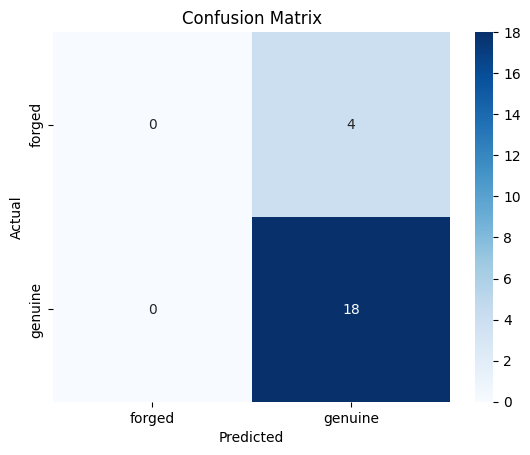

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you are using ImageFolder for validation set
class_names = val_dataset.classes  # Get class names from the validation dataset

# Collect predictions and true labels from validation set
y_true, y_pred = collect_predictions_and_labels(trained_model, val_loader)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Save the trained model
torch.save(trained_model.state_dict(), 'forgery_detection_model.pth')
print("Model saved as 'forgery_detection_model.pth'")


Model saved as 'forgery_detection_model.pth'


# **MODEL TESTING ON VALIDATION SET**

In [19]:
import os
import torch
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import datasets

# Define the function to predict on validation set and save results to CSV
def process_and_predict_images(model, loader, class_names):
    model.eval()  # Set the model to evaluation mode
    results = []

    # Loop through the validation set and make predictions
    for inputs, labels, paths in loader:
        inputs = inputs.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            confidence = torch.softmax(outputs, dim=1).max(dim=1)[0].cpu().numpy() * 100  # Confidence in percentage
            predictions = predicted.cpu().numpy()

            # Save the predictions for each file
            for i in range(len(paths)):
                file_name = os.path.basename(paths[i])  # Get the filename from the path
                is_forged = bool(predictions[i])  # 0 -> genuine, 1 -> forged
                confidence_score = confidence[i]
                results.append((file_name, is_forged, confidence_score))

    # Convert the results into a DataFrame
    df = pd.DataFrame(results, columns=["file_name", "is_forged", "confidence"])

    # Save the DataFrame as a CSV file
    df.to_csv("forgery_predictions.csv", index=False)
    print("Predictions saved to 'forgery_predictions.csv'")

# Custom dataset loader for getting image paths along with data
class ImageFolderWithPaths(datasets.ImageFolder):
    # Override the __getitem__ method to also return the image paths
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        return original_tuple + (path,)

# Load the validation dataset using the custom ImageFolder class
val_dataset_with_paths = ImageFolderWithPaths(val_dir, transform=data_transforms['val'])

# Create DataLoader for validation set with paths
val_loader_with_paths = DataLoader(val_dataset_with_paths, batch_size=16, shuffle=False)

# Call the function to predict and save results on the validation set
process_and_predict_images(trained_model, val_loader_with_paths, val_dataset_with_paths.classes)


Predictions saved to 'forgery_predictions.csv'


# **WEB APP**

In [20]:
!pip install pyngrok
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [21]:
%%writefile app.py
import streamlit as st
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import time
import pandas as pd

# Load the trained model (architecture + weights)
@st.cache_resource
def load_model():
    model = models.resnet50(pretrained=False)  # Use the same model as trained
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification (genuine vs forged)

    model.load_state_dict(torch.load('forgery_detection_model.pth', map_location=torch.device('cpu')))
    model.eval()
    return model

# Define the image transformations (same as during training)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prediction function
def predict_image(image, model):
    if image.mode != "RGB":
        image = image.convert("RGB")

    image = data_transforms(image)

    if image.shape[0] != 3:
        st.error("Image has an unexpected number of channels.")
        return None, None

    image = image.unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        confidence = torch.softmax(output, dim=1).max().item() * 100
    return predicted.item(), confidence

# Streamlit app interface
st.set_page_config(page_title="Document Forgery Detection", layout="wide")

# Display the title and a brief description
st.title("🔍 Document Forgery Detection")
st.markdown("**Upload images of documents and find out if they are _genuine_ or _forged_ using our advanced detection model.**")

# Upload images
uploaded_files = st.file_uploader("Upload one or more document images:", type=["jpg", "png", "jpeg", "tif", "tiff"], accept_multiple_files=True)

if uploaded_files:
    st.write(f"🖼️ You've uploaded {len(uploaded_files)} document(s).")

    model = load_model()  # Load model only when files are uploaded

    # Create tabs for better navigation
    tab1, tab2, tab3 = st.tabs(["📝 Predictions", "📊 Download Results", "📖 Documentation"])

    # Tab 1: Predictions
    with tab1:
        st.subheader("📋 Results")
        y_true = []
        y_pred = []
        file_names = []
        results = []

        cols = st.columns(3)  # Display images in 3-column layout

        # Process and predict for each uploaded file
        for i, uploaded_file in enumerate(uploaded_files):
            image = Image.open(uploaded_file)
            with cols[i % 3]:
                st.image(image, caption=f"{uploaded_file.name}", use_column_width=True)

                label, confidence = predict_image(image, model)

                if label is not None:
                    y_true.append(label)
                    y_pred.append(label)
                    file_names.append(uploaded_file.name)
                    result_label = "Genuine" if label == 0 else "Forged"

                    # Display result with color coding
                    st.markdown(f"<span style='color: {'green' if label == 0 else 'red'}'>**{result_label}** - Confidence: {confidence:.2f}%</span>", unsafe_allow_html=True)

                    # Store the result for later
                    results.append({
                        "File Name": uploaded_file.name,
                        "Result": result_label,
                        "Confidence": f"{confidence:.2f}%",
                    })
                    time.sleep(0.5)  # Simulate processing time for better UX

    # Tab 2: Download Results
    with tab2:
        st.subheader("📊 Download Prediction Report")
        if results:
            report_df = pd.DataFrame(results)
            st.write(report_df)

            # Allow users to download the CSV
            csv = report_df.to_csv(index=False)
            st.download_button("Download Prediction Report", csv, "prediction_report.csv", "text/csv", key="download-report")
        else:
            st.info("Please make predictions first in the 'Predictions' tab.")

    # Tab 3: Documentation
    with tab3:
        st.subheader("📖 How the Detection Works")
        st.markdown("""
        Our forgery detection model is based on ResNet50, a deep learning model pre-trained on the ImageNet dataset.
        We fine-tuned the model using a custom dataset of genuine and forged documents.

        ### Steps:
        1. Upload one or more images in common formats (JPG, PNG, TIFF).
        2. The model will analyze each document to determine whether it's genuine or forged.
        3. Results include confidence scores for each prediction.

        ### Limitations:
        - The model works best with clean, high-quality images of documents.
        - For very complex forgeries, the model may require additional tuning and training data.
        """)

else:
    st.info("Please upload document images to begin the analysis.")


Writing app.py


In [22]:
# Start the Streamlit app
!streamlit run app.py &>/dev/null&


# **LOCAL TUNNEL DEPLOYMENT USING NGROK**

In [ ]:
!ngrok authtoken <YOUR AUTH TOKEN>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pkill ngrok


In [ ]:
from pyngrok import ngrok

# Connect ngrok on port 8501 with explicit protocol
public_url = ngrok.connect(addr='8501', proto='http')

# Print the public URL where Streamlit is running
print(f"Streamlit app running at: {public_url}")
